In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_state_qsphere
from qiskit.visualization import plot_histogram
from qiskit import Aer, execute
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit.add_control import add_control
import numpy as np

Here I'm training on Stean [7,1,3]-code (in stabiliser formalism)

*initializing

*adding error

*syndrom finding

*mearsument

*correction erros

In [ ]:
# Need to write function for general measurement scheme

In [2]:
def initialize_qubit(given_circuit, qubit_index):
    
    custom_state = [np.sqrt(0.7), np.sqrt(0.3)]
    given_circuit.initialize(custom_state, qubit_index)
    
    return given_circuit

In [7]:
# K1 = IIIXXXX
# K2 = XIXIXIX
# K3 = IXXIIXX
# K4 = IIIZZZZ
# K5 = ZIZIZIZ
# K6 = IZZIIZZ

Stabilizers = {
    "K1": {"X": [3, 4, 5, 6], "Y": [], "Z": []},
    "K2": {"X": [0, 2, 4, 6], "Y": [], "Z": []},
    "K3": {"X": [1, 2, 5, 6], "Y": [], "Z": []},
    "K4": {"X": [], "Y": [], "Z": [3, 4, 5, 6]},
    "K5": {"X": [], "Y": [], "Z": [0, 2, 4, 6]},
    "K6": {"X": [], "Y": [], "Z": [1, 2, 5, 6]},
}

# Lookuptable = {
#     0: {"value": [4,5,6],
#         0: {"value": [4,5],
#             0: {"value": [6]},
#             1: {"value": []}
#         },
#         1: {"value": [6],
#             0: {"value": [5]},
#             1: {"value": [4]}
#         }
#     },
#     1: {"value": [0,1,2,3],
#         0: {"value": [1,2],
#             0: {"value": [3]},
#             1: {"value": [0]}
#         },
#         1: {"value": [0,3],
#             0: {"value": [2]},
#             1: {"value": [1]}
#         }
#     }
# }

Lookuptable = [
    "100",
    "110",
    "111",
    "101",
    "010",
    "011",
    "001"
]

In [8]:
# CORRECTION
def correction_z(qcirc, clbits_z):

    for i in range(len(Lookuptable)):
        qcirc.z(i).c_if(clbits_z, eval("0b"+Lookuptable[i]))

    return qcirc


def correction_x(qcirc, clbits_x):

    for i in range(len(Lookuptable)):
        qcirc.x(i).c_if(clbits_x, eval("0b"+Lookuptable[i]))

    return qcirc


In [11]:
# creating STABILIZER
@staticmethod
def stabilizer(qcirc, stblzr_name, ctrl_index):
    
    X = Stabilizers[stblzr_name]["X"]
    Y = Stabilizers[stblzr_name]["Y"]
    Z = Stabilizers[stblzr_name]["Z"]
    if len(X) != 0:
        qcirc.cx(ctrl_index, X)
    if len(Y) != 0:
        qcirc.cy(ctrl_index, Y)
    if len(Z) != 0:
        qcirc.cz(ctrl_index, Z)
    qcirc.barrier() 

    return qcirc
    

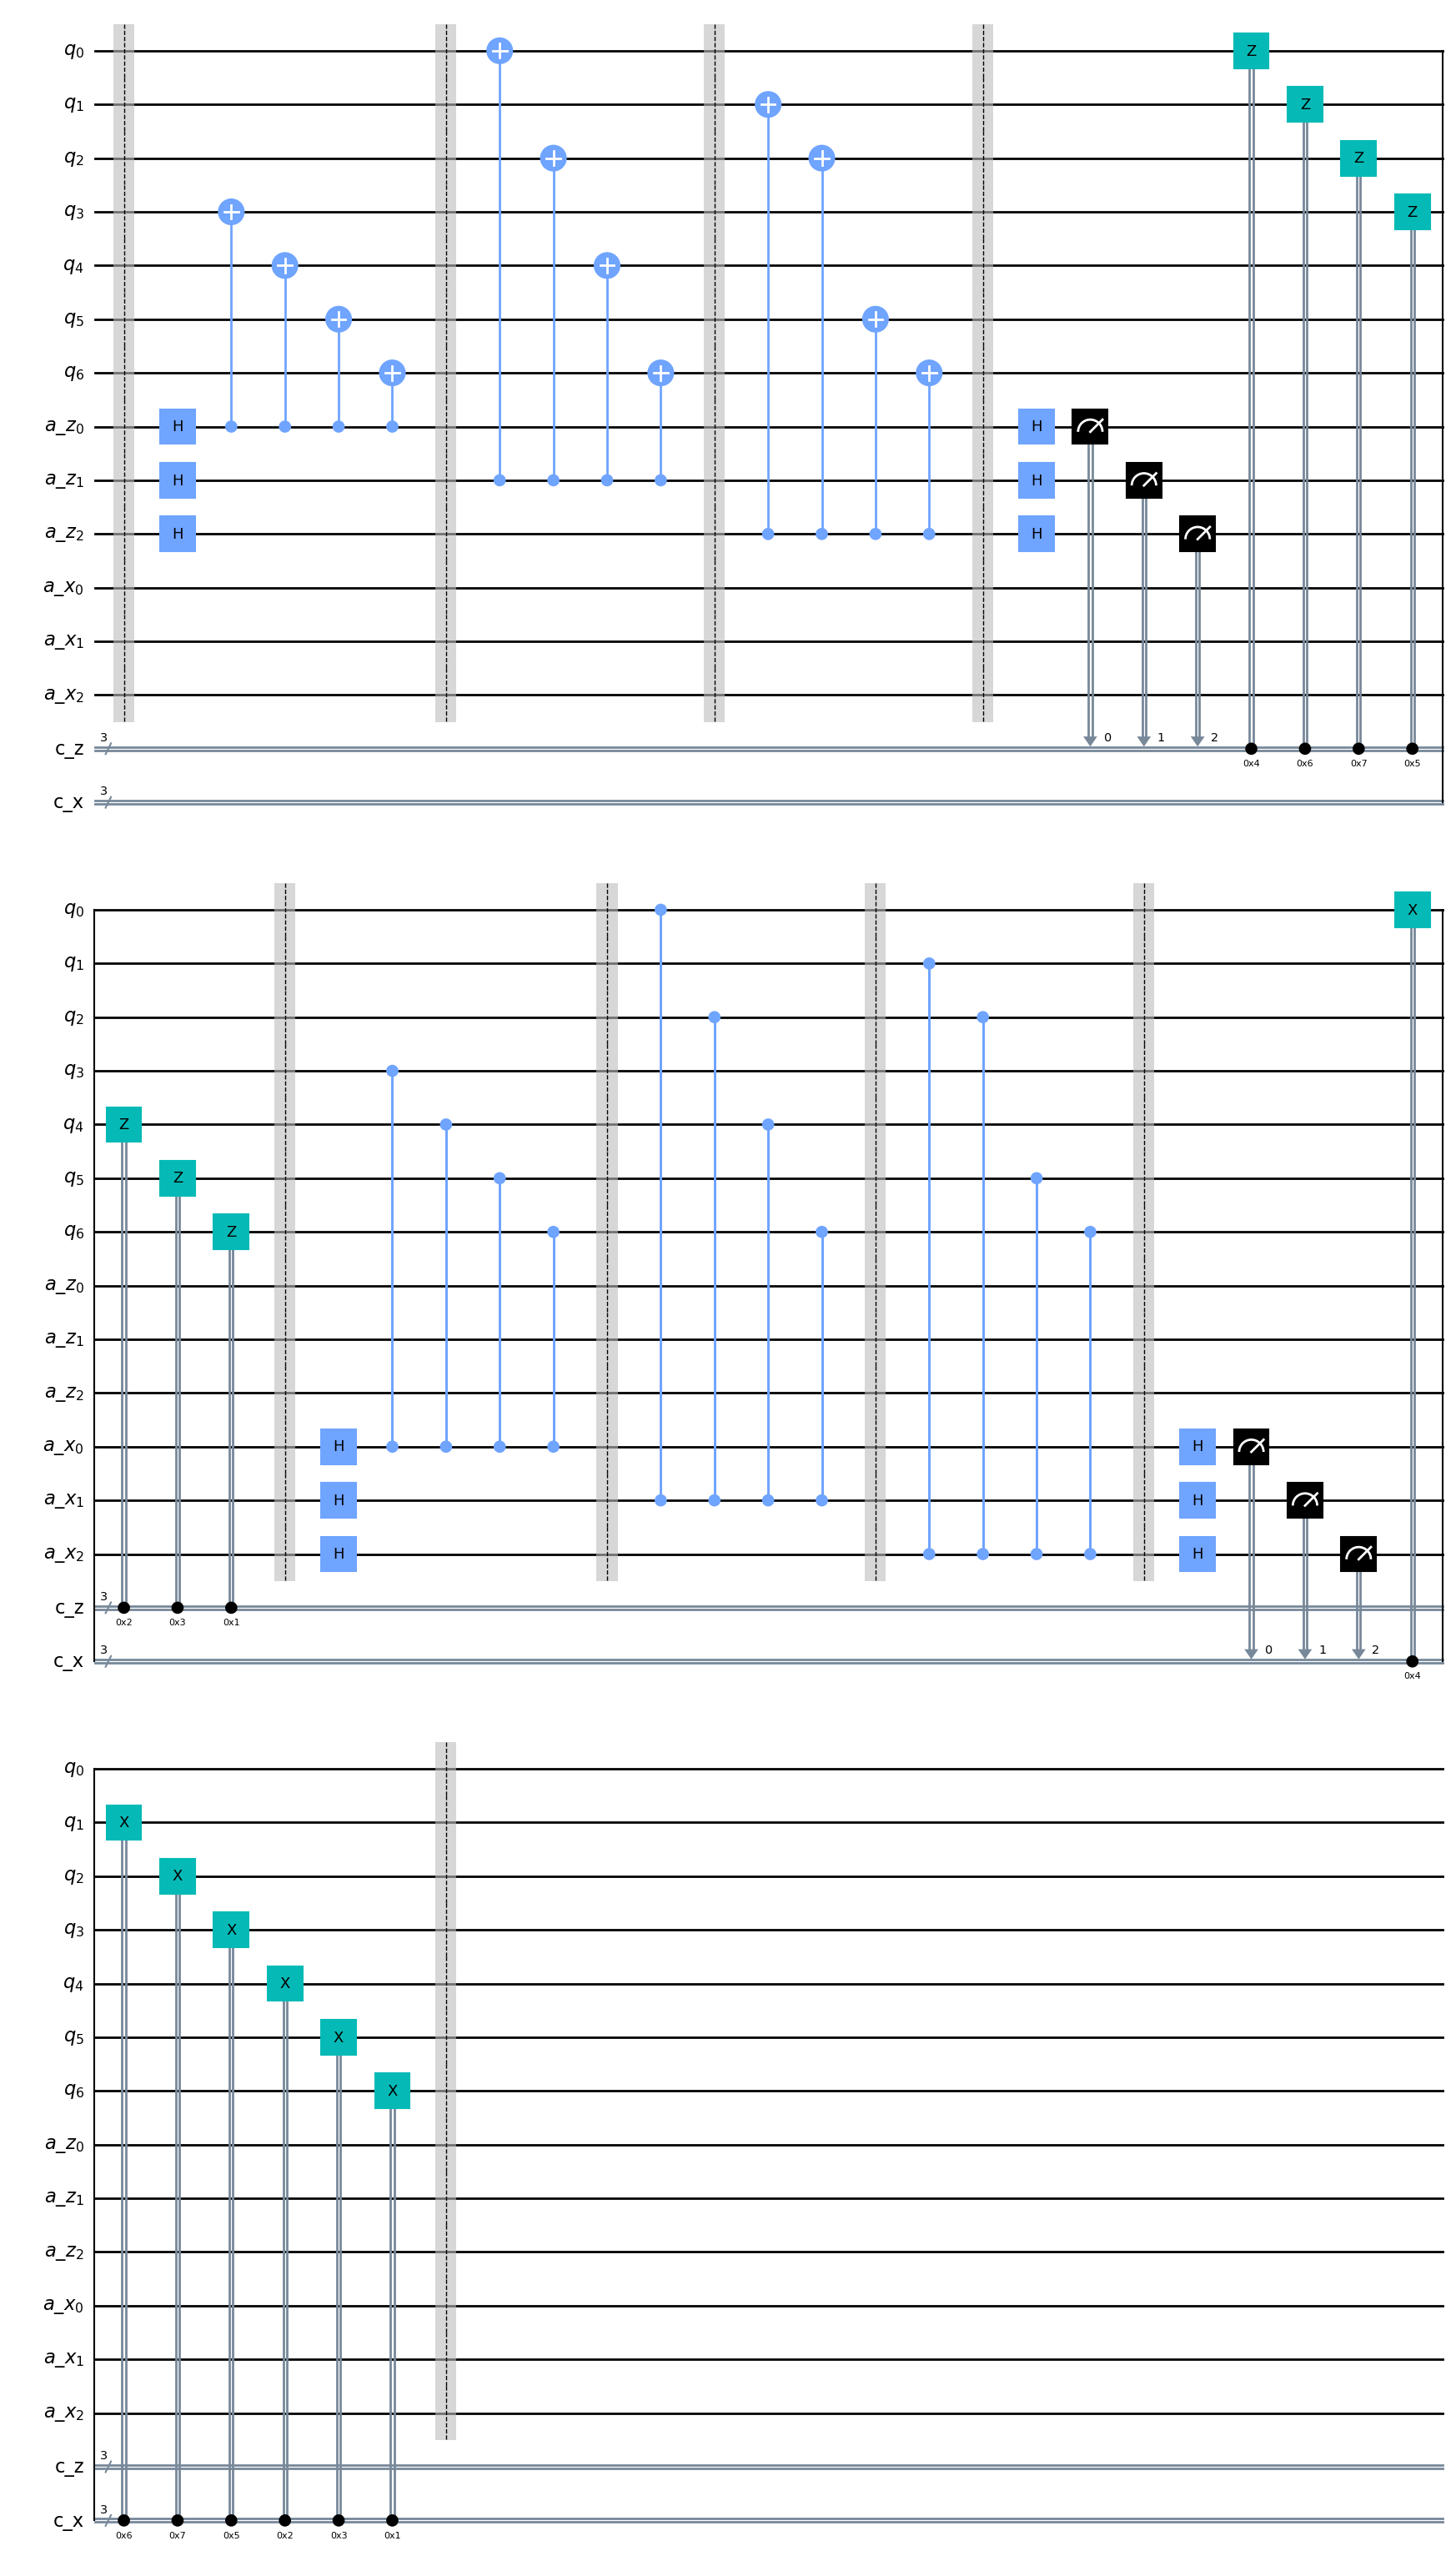

In [12]:
num_qubits = 7
phys_qubits = QuantumRegister(num_qubits, 'q')
num_anclq = 3
ancila_z = QuantumRegister(num_anclq, 'a_z')
ancila_x = QuantumRegister(num_anclq, 'a_x')
cl_z = ClassicalRegister(num_anclq, 'c_z')
cl_x = ClassicalRegister(num_anclq, 'c_x')
qc = QuantumCircuit(phys_qubits, ancila_z, ancila_x, cl_z, cl_x)

# Initialization -----------------------------
anc_z_state = Statevector.from_label('000')
anc_x_state = Statevector.from_label('000')
# qc.initialize_qubit(qc, phys_qubits[0])
# qc.logical_qubit(qc, phys_qubits)
qc.barrier() 
#---------------------------------------------

qc.h(range(num_qubits, num_qubits + num_anclq))

# X-stabilizers
for i in range(num_anclq):
    stabilizer(qc, f'K{1+i}', num_qubits + i)

qc.h(range(num_qubits, num_qubits + num_anclq))

# Measurement M{1-3}
qc.measure(ancila_z, cl_z)

# Correction_Z
correction_z(qc, cl_z)
qc.barrier() 
#---------------------------------------------

qc.h(range(num_qubits + num_anclq, num_qubits + 2*num_anclq))

# Z-stabilizers
for i in range(num_anclq, 2*num_anclq):
    stabilizer(qc, f'K{1+i}', num_qubits + i)

qc.h(range(num_qubits + num_anclq, num_qubits + 2*num_anclq))

# Measurement M{4-6}
qc.measure(ancila_x, cl_x)

# Correction_X
correction_x(qc, cl_x)
qc.barrier() 
#---------------------------------------------
qc.draw('mpl')